This approach substitutes a token in a test case by it's synonym, the thesaurus below lists the token:synonym data. Every token in each test case is analysed and, if it is in the thesaurus, the replacement by it's synonym is done.

The ideia behind is that if we have more broad words that could help the model classify as flaky or not.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib import pyplot as plt
import preprocessing as pp

In [2]:
thesaurus = {
    "services":"network web",
    "service":"network web",
    "client":"network",
    "table":"database",
    "thread":"concurrency",
    "id":"database",
    "server":"network",
    "call":" ",
    "action":"concurrency",
    "cluster":"network node",
    "node":"network",
    "nodes":"network",
    "job":"concurrency",
    "jobs":"concurrency",
    "job1":"concurrency",
    "job2":"concurrency",
    "coordinator":"concurrency",
    "nodes":"network",
    "block":"io",
    "get":"network",
    "runtest":"test",
    "row":"database",
    "enqueue":"stack",
    "oozie":" ",
    "coord":" ",
    "url":"web network",
    "geturl":"web network",
    "assert":" ",
    "fs":"io file",
    "assertequals":" ",
    "assertsame":" ",
    "assertthat":" ",
    "asserttrue":" ",
    "assertnotnull":" ",
    "assertnull":" ",
    "assertfalse":" ",
    "testscan":" ",
    "run":"concurrency",
    "file":"file io",
    "http":"web network",
    "httprequest":"web network",
    "createrequest":"web network",
    "request":"web network",
    "bytes":"database",
    "tobyte":"database",
    "tobytes":"database",
    "tostring":"string",
    "foo":" ",
    "value":" ",
    "connection":"network database",
    "createtable":"database",
    "createfile":"file io",
    "mkdir":"io",
    "xml":"file",
    "sleep":"concurrency",
    "insert":"database",
    "log":"file io",
    "close":"file network database",
    "currenttimemillis":"time",
    "timeunit":"time",
    "mock":" ",
    "record":"database",
    "getfilesystem":"file io",
    "workflow":"concurrency",
    "worklfow":"concurrency",
    "system":"io",
    "controller":"concurrency",
    "runtestscenarioconnect":" ",
    "readjsonfile":"io",
    "test1":" ",
    "test":" ",
    "open":"file io",
    "gettime":"time",
    "function":" ",
    "getendpointbean":" ",
    "wf":" ",
    "dir":"io",
    "path":"file io",
    "mtfs":" ",
    "the":" ",
    "name":" ",
    "have":" ",
    "not":" ",
    "is":" ",
    "user":" ",
    "be":" ",
    "off":" ",
    "been":" ",
    "context":" ",
    "ok":" ",
    "next":" ",
    "len":" ",
    "in":" ",
    "to":" ",
    "end":" ",
    "and":" ",
    "of":" ",
    "equals":" ",
    "should":" ",
    "createconnection":"network",
    "count":" ",
    "tablename":"database",
    "column":"database",
    "serverport":"network",
    "getsockettimeout":"network",
    "host":"network",
    "pool":"network database",
    "assertjob":" ",
    "gethttpconnectioncount":"web network",
    "getcolumn":"database",
    "getcolumns":"database",
    "columnnames":"database",
    "createcolumn":"database",
    "hostname":"network",
    "host1":"network",
    "tostrings":"string",
    "testutils":" ",
    "testfile":"io",
    "rows":"database",
    "method":" "
}

In [4]:
def document_to_synonims(document):
    '''Replaces tokens of a document by its synonims/semantic related words.
        Synset_option: 1 = synonyms 
                       2 = semantic related words'''
    
    synset = []
    for word in document:
        terms = thesaurus.get(word)    
        if bool(terms):   
            synset.append(terms)
        else:
            synset.append(word)
            
    return ' '.join(map(str, synset))


def preprocess_tokens(data):
    '''Tokenizes each document before replacing synonims.
        Returns: list of processed documents'''
    
    processed_tokens = [] 
    for row in data['clean_token']:
        tokenized_row = word_tokenize(row)
        processed_row = document_to_synonims(tokenized_row)
        processed_tokens.append(processed_row)
        
    return processed_tokens

def preprocess(token):
    token = str(token) 
    token_lowered = token.lower()
    
    #any url turns into urllink
    url_pattern = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    token_url = re.sub(url_pattern, 'urllink', token_lowered)
    
    #any date to 'date'
    date_pattern = '([12]\d{3}/(0[1-9]|1[0-2])/(0[1-9]|[12]\d|3[01]))|([12]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01]))|([12]\d{3}/(0[1-9]|1[0-2])/(0[1-9]|[12]\d|3[01]))'
    token_dates = re.sub(date_pattern, 'date', token_url)
    
    #any ip to ipaddrezz
    ip_pattern = '(([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])\.){3}([0-9]|[1-9][0-9]|1[0-9]{2}|2[0-4][0-9]|25[0-5])'
    token_ip = re.sub(ip_pattern, ' ipaddrezz ', token_dates)
    
    #removing number
    token_num = re.sub(r'\b[0-9]+\b', ' ', token_ip)
    
    #removing special characters that aren't letters or numbers 
    special_character_pattern = '[^A-Za-z0-9]+'
    token_char = re.sub(special_character_pattern, ' ', token_num)
    
    return token_char

### Loading data

In [5]:
msr_data = pd.read_csv('data/msr/raw_msr_dataset.csv', encoding = 'ANSI', index_col=False)
msr_data['clean_token'] = msr_data['token'].map(lambda s:preprocess(s)) 
msr_data['processed_token'] = preprocess_tokens(msr_data)
y_msr = msr_data['class']
msr = msr_data.drop(columns=['class'])

X_train, X_test, y_train, y_test = train_test_split(msr_data['processed_token'], y_msr, 
                                                    train_size=0.8, random_state=33, shuffle=True)

In [6]:
X_train

1407    check for resolved conf e concurrency network ...
865     add network def   invalid execution file io on...
1528    property had invalid int   but was read succes...
328     a a cc e e gg i i m m q q u u y y kk oo ss ww ...
1690    network web network database start network add...
                              ...                        
57        equal   false equal   true network join jms ...
2706    network instances set network     network inst...
578     network web network database network address a...
1752    monotonic now increment   network file io warn...
2439    aap sg qaaad 0o eaaaa kbaaaap sg qaaad 0o eaaa...
Name: processed_token, Length: 2243, dtype: object

In [8]:
new_data = pd.read_csv('data/new/raw_new_dataset.csv')
new_data['clean_token'] = new_data['token'].map(lambda t:preprocess(t)) 
new_data['processed_token'] = preprocess_tokens(new_data)
y_new = new_data['class']
new_data = new_data.drop(columns=['class'])

In [9]:
def plot_word_count(data, n):
    counter = CountVectorizer()
    bow = counter.fit_transform(data)
    sparse_matrix = pd.DataFrame(bow.toarray(), columns = counter.get_feature_names())
    counts = sparse_matrix.sum().sort_values(ascending=False)

    sns.barplot(x=counts.index[:n], y=counts.values[:n], palette='Blues_d')
    plt.xticks(rotation=90)
    plt.title('Word frequency in corpus')

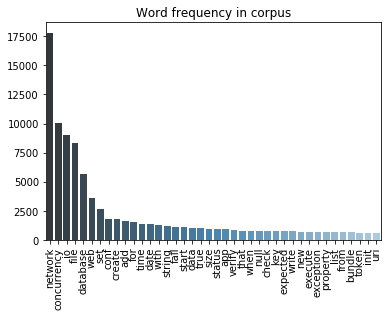

In [10]:
plot_word_count(msr_data['processed_token'], n=40)

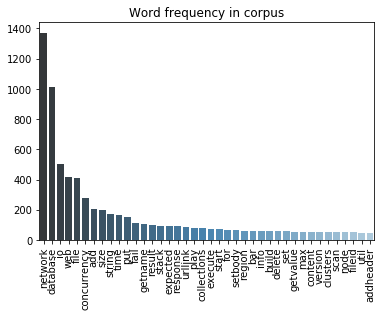

In [11]:
plot_word_count(new_data['processed_token'], n=40)

In [13]:
new_data['processed_token']

0       subject logger header synchronous setlayout er...
1       subject logger header synchronous setlayout er...
2       msg getclass debug getname mp getbody logger s...
3       html getclass font color red b b font msg2 fon...
4       msg d w d d d w getname logger getmessagelist ...
                              ...                        
1456    fail       invalid delta tuserinfo constructor...
1457    min   addownbytes   max   tuserinfo generaltes...
1458    min     max   tuserinfo getuseridtest   k getu...
1459                        tuserinfo timeouttest timeout
1460    userinfo   database mownbytes mlastheartbeatms...
Name: processed_token, Length: 1461, dtype: object

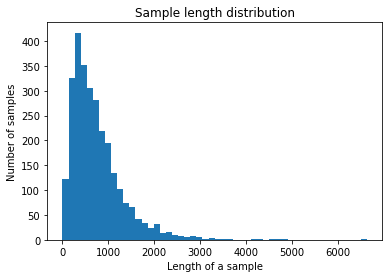

In [14]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()
    
plot_sample_length_distribution(msr_data['processed_token'])

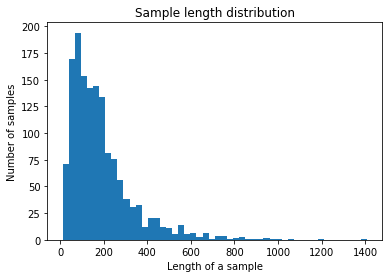

In [15]:
plot_sample_length_distribution(new_data['processed_token'])

In [16]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

get_num_words_per_sample(msr_data['processed_token'])

78.0

In [17]:
get_num_words_per_sample(new_data['processed_token'])

15.0

###  Model cross-validation

In [22]:
from sklearn.model_selection import cross_val_score

text_clf = Pipeline([
                      ('vectorizer', CountVectorizer(stop_words='english')),
                      ('model', MultinomialNB())])

scores = cross_val_score(text_clf, msr_data['processed_token'], y_msr, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.92 (+/- 0.02)


### Training model

In [24]:
text_clf.fit(msr_data['processed_token'], y_msr)

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('model', MultinomialNB())])

### Evaluating model on new data

In [26]:
new_preds = text_clf.predict(new_data['processed_token'])
print(classification_report(y_new, new_preds))
print('f1', f1_score(y_new, new_preds))

              precision    recall  f1-score   support

           0       0.54      0.45      0.49       724
           1       0.53      0.62      0.58       737

    accuracy                           0.54      1461
   macro avg       0.54      0.54      0.53      1461
weighted avg       0.54      0.54      0.53      1461

f1 0.5755485893416927


In [28]:
def show_most_informative_features(vectorizer, clf, n=100):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        #print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        print(coef_2, fn_2)
        
show_most_informative_features(text_clf['vectorizer'], text_clf['model'])

-2.6349012395876397 network
-2.8582570375332317 concurrency
-3.2757878517848926 io
-3.323136902102492 file
-3.543159799764531 database
-4.264056893277378 web
-4.658543524959219 set
-4.891043492327884 date
-4.9737910975121205 add
-4.986191610710576 conf
-5.014209710960147 create
-5.191229125339068 time
-5.224602634155574 app
-5.312025449126733 start
-5.358780648205795 data
-5.399710453625837 status
-5.453702804982552 fail
-5.5274825675167865 bundle
-5.603831238762376 execute
-5.6188190297278675 string
-5.654689655995867 true
-5.6955116505161225 size
-5.717490557234897 property
-5.796453601041699 purged
-5.804501934224527 check
-5.841543205904876 uri
-5.869175144566962 write
-5.875661653796569 node
-5.899812114028852 null
-5.968804985515804 instance
-5.97118877687108 utils
-5.978374436531954 error
-5.990466482296983 list
-6.012607608174196 case
-6.025123416106027 expected
-6.0741655011736295 input
-6.079470553403323 init
-6.079470553403323 cmd
-6.084803899378685 delete
-6.095556691154948

### Experimenting with RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier

text_clf2 = Pipeline([
    ('vectorizer', CountVectorizer(max_features=1000)),
    ('model', RandomForestClassifier())])

text_clf2.fit(X_train, y_train)
preds = text_clf2.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       283
           1       0.96      0.92      0.94       278

    accuracy                           0.94       561
   macro avg       0.94      0.94      0.94       561
weighted avg       0.94      0.94      0.94       561



In [30]:
importances = pd.DataFrame(text_clf2['model'].feature_importances_, 
                           index = text_clf2['vectorizer'].get_feature_names(),
                           columns=['importance']).sort_values('importance', ascending=False)

importances[:15]

,importance
concurrency,0.045577
database,0.031414
network,0.027112
getid,0.021933
node,0.021728
app,0.017852
dfs,0.012132
io,0.011571
getstatus,0.011499
jpa,0.010786


Text(0, 0.5, 'Token')

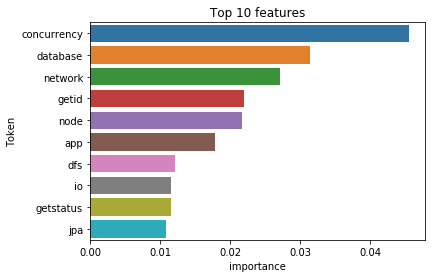

In [31]:
sns.barplot(y=importances.index[:10], x=importances['importance'][:10])
plt.title('Top 10 features')
plt.ylabel('Token')

### Evaluating RF model on new data

In [32]:
new_preds = text_clf2.predict(new_data['processed_token'])
print(classification_report(y_new, new_preds))
print('f1', f1_score(y_new, new_preds))

              precision    recall  f1-score   support

           0       0.51      0.98      0.67       724
           1       0.78      0.08      0.14       737

    accuracy                           0.52      1461
   macro avg       0.64      0.53      0.40      1461
weighted avg       0.64      0.52      0.40      1461

f1 0.138442521631644
